In [22]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

DATA_PATH = './Datasets/Cards/'

Directorio actual: /tf/CNN-Cards


In [23]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from scipy.ndimage import rotate as scipy_rotate

# Set seeds para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Global variables
SIZE = 224
NUM_CLASSES = 13  # A, 2-10, J, Q, K
SUIT_CLASSES = 4  # clubs, diamonds, hearts, spades
EPOCHS = 125  # Optimo parece ser alrededor de 100-120
PATIENCE_ES = 20  # Ajustado de 25 a 20
BATCH_SIZE = 128
LABEL_SMOOTHING = 0.1  # Para regularización

path_models = 'Models'
path_results = 'Results'

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {tf.config.list_physical_devices("GPU")}')

TensorFlow version: 2.15.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Crear generador de datos personalizado

Parseamos las etiquetas del nombre de las carpetas (ej: "ace of clubs" -> num=ace, suit=clubs)

In [24]:
# Mapeo de nombres a indices
NUM_MAP = {
    'ace': 0, 'two': 1, 'three': 2, 'four': 3, 'five': 4,
    'six': 5, 'seven': 6, 'eight': 7, 'nine': 8, 'ten': 9,
    'jack': 10, 'queen': 11, 'king': 12
}

SUIT_MAP = {
    'clubs': 0, 'diamonds': 1, 'hearts': 2, 'spades': 3
}

# Inversos para visualizacion
NUM_NAMES = {v: k for k, v in NUM_MAP.items()}
SUIT_NAMES = {v: k for k, v in SUIT_MAP.items()}

def parse_card_label(folder_name):
    """Extrae numero y palo del nombre de la carpeta"""
    # Formato: "ace of clubs", "two of hearts", etc.
    # Joker no tiene palo - lo excluimos
    if 'joker' in folder_name.lower():
        return None, None
    
    parts = folder_name.lower().split(' of ')
    if len(parts) != 2:
        return None, None
    
    num_name, suit_name = parts
    num_idx = NUM_MAP.get(num_name)
    suit_idx = SUIT_MAP.get(suit_name)
    
    return num_idx, suit_idx

# Test
print(parse_card_label('ace of clubs'))  # (0, 0)
print(parse_card_label('king of hearts'))  # (12, 2)
print(parse_card_label('joker'))  # (None, None)

(0, 0)
(12, 2)
(None, None)


In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence

class MultiOutputDataGenerator(Sequence):
    """Generador de datos para modelo multi-output"""
    
    def __init__(self, directory, batch_size=32, target_size=(224, 224), 
                 shuffle=True, augment=False):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        
        # Recopilar todos los archivos de imagen
        self.samples = []
        for folder in Path(directory).iterdir():
            if folder.is_dir():
                num_idx, suit_idx = parse_card_label(folder.name)
                if num_idx is not None and suit_idx is not None:
                    for img_path in folder.glob('*.jpg'):
                        self.samples.append((str(img_path), num_idx, suit_idx))
                    for img_path in folder.glob('*.png'):
                        self.samples.append((str(img_path), num_idx, suit_idx))
        
        print(f'Cargadas {len(self.samples)} imagenes de {directory}')
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.samples) // self.batch_size
    
    def __getitem__(self, idx):
        batch_samples = self.samples[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = np.zeros((len(batch_samples), *self.target_size, 3), dtype=np.float32)
        y_num = np.zeros((len(batch_samples), NUM_CLASSES), dtype=np.float32)
        y_suit = np.zeros((len(batch_samples), SUIT_CLASSES), dtype=np.float32)
        
        for i, (img_path, num_idx, suit_idx) in enumerate(batch_samples):
            img = load_img(img_path, target_size=self.target_size)
            img_array = img_to_array(img) / 255.0
            
            if self.augment:
                img_array = self._augment(img_array)
            
            X[i] = img_array
            y_num[i, num_idx] = 1.0
            y_suit[i, suit_idx] = 1.0
        
        return X, {'num_output': y_num, 'suit_output': y_suit}
    
    def _augment(self, img):
        """Aplicar augmentacion avanzada"""
        # Random flip horizontal
        if np.random.random() > 0.5:
            img = np.fliplr(img)
        
        # Random rotation (±15 grados)
        if np.random.random() > 0.5:
            angle = np.random.uniform(-15, 15)
            img = scipy_rotate(img, angle, reshape=False, mode='nearest')
        
        # Random brightness (0.8-1.2)
        if np.random.random() > 0.5:
            factor = np.random.uniform(0.8, 1.2)
            img = np.clip(img * factor, 0, 1)
        
        # Random contrast (0.8-1.2)
        if np.random.random() > 0.5:
            factor = np.random.uniform(0.8, 1.2)
            mean = img.mean()
            img = np.clip((img - mean) * factor + mean, 0, 1)
        
        # Random crop and resize (90-100%)
        if np.random.random() > 0.5:
            h, w = img.shape[:2]
            crop_factor = np.random.uniform(0.9, 1.0)
            new_h, new_w = int(h * crop_factor), int(w * crop_factor)
            top = np.random.randint(0, h - new_h + 1)
            left = np.random.randint(0, w - new_w + 1)
            img = img[top:top+new_h, left:left+new_w]
            # Resize back
            img_uint8 = (img * 255).astype(np.uint8)
            img = cv2.resize(img_uint8, (w, h)) / 255.0
        
        # Perspective transformation
        if np.random.random() > 0.5:
            h, w = img.shape[:2]
            distortion = 0.15
            pts1 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
            pts2 = np.float32([
                [np.random.uniform(0, w*distortion), np.random.uniform(0, h*distortion)],
                [w - np.random.uniform(0, w*distortion), np.random.uniform(0, h*distortion)],
                [np.random.uniform(0, w*distortion), h - np.random.uniform(0, h*distortion)],
                [w - np.random.uniform(0, w*distortion), h - np.random.uniform(0, h*distortion)]
            ])
            M = cv2.getPerspectiveTransform(pts1, pts2)
            img_uint8 = (img * 255).astype(np.uint8)
            img = cv2.warpPerspective(img_uint8, M, (w, h)) / 255.0
        
        # Gaussian noise (std=0.01)
        if np.random.random() > 0.5:
            noise = np.random.normal(0, 0.01, img.shape)
            img = np.clip(img + noise, 0, 1)
        
        # Color jittering - Hue ±0.05, Saturation ±0.1
        if np.random.random() > 0.5:
            img_uint8 = (img * 255).astype(np.uint8)
            hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)
            hsv[:, :, 0] = np.clip(hsv[:, :, 0] + np.random.uniform(-9, 9), 0, 179)  # Hue
            hsv[:, :, 1] = np.clip(hsv[:, :, 1] * np.random.uniform(0.9, 1.1), 0, 255)  # Saturation
            hsv = hsv.astype(np.uint8)
            img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB) / 255.0
        
        # Random erasing / Cutout (10% del área)
        if np.random.random() > 0.5:
            h, w = img.shape[:2]
            area = h * w
            target_area = np.random.uniform(0.05, 0.1) * area
            aspect_ratio = np.random.uniform(0.3, 3.0)
            
            erase_h = int(np.sqrt(target_area * aspect_ratio))
            erase_w = int(np.sqrt(target_area / aspect_ratio))
            
            if erase_h < h and erase_w < w:
                top = np.random.randint(0, h - erase_h)
                left = np.random.randint(0, w - erase_w)
                img[top:top+erase_h, left:left+erase_w] = np.random.uniform(0, 1)
        
        return img.astype(np.float32)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.samples)

In [28]:
# Crear generadores
train_gen = MultiOutputDataGenerator(
    DATA_PATH + 'train',
    batch_size=BATCH_SIZE,
    target_size=(SIZE, SIZE),
    shuffle=True,
    augment=True
)

valid_gen = MultiOutputDataGenerator(
    DATA_PATH + 'valid',
    batch_size=BATCH_SIZE,
    target_size=(SIZE, SIZE),
    shuffle=False,
    augment=False
)

test_gen = MultiOutputDataGenerator(
    DATA_PATH + 'test',
    batch_size=BATCH_SIZE,
    target_size=(SIZE, SIZE),
    shuffle=False,
    augment=False
)

Cargadas 7582 imagenes de ./Datasets/Cards/train
Cargadas 260 imagenes de ./Datasets/Cards/valid
Cargadas 260 imagenes de ./Datasets/Cards/valid
Cargadas 260 imagenes de ./Datasets/Cards/test
Cargadas 260 imagenes de ./Datasets/Cards/test


Shape X: (128, 224, 224, 3)
Shape y_num: (128, 13)
Shape y_suit: (128, 4)


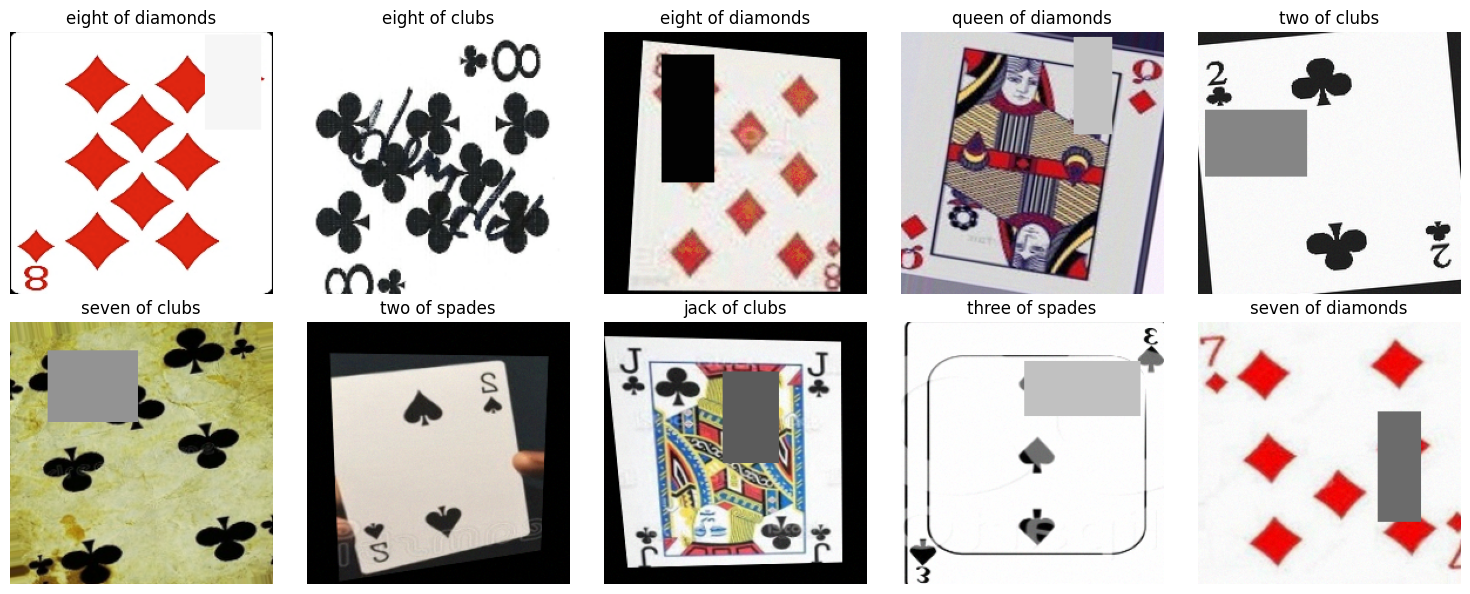

In [29]:
# Verificar un batch
X_sample, y_sample = train_gen[0]
print(f'Shape X: {X_sample.shape}')
print(f'Shape y_num: {y_sample["num_output"].shape}')
print(f'Shape y_suit: {y_sample["suit_output"].shape}')

# Visualizar una muestra
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(X_sample[i])
    num_idx = y_sample['num_output'][i].argmax()
    suit_idx = y_sample['suit_output'][i].argmax()
    ax.set_title(f'{NUM_NAMES[num_idx]} of {SUIT_NAMES[suit_idx]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Construir modelo Multi-Output

In [30]:
def build_multioutput_model(input_shape=(224, 224, 3), num_classes=13, suit_classes=4):
    """Modelo multi-output optimizado con backbone MobileNetV2"""
    
    # Backbone compartido - MobileNetV2 preentrenado
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    # Descongelar más capas para mejor fine-tuning (últimas 50 capas)
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    for layer in base_model.layers[-50:]:
        layer.trainable = True
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Shared hidden layers - capas más profundas
    shared = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    shared = BatchNormalization()(shared)
    shared = Dropout(0.4)(shared)
    
    shared = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(shared)
    shared = BatchNormalization()(shared)
    shared = Dropout(0.4)(shared)
    
    shared = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(shared)
    shared = BatchNormalization()(shared)
    shared = Dropout(0.3)(shared)
    
    # Cabeza para Numero (13 clases) - capas adicionales
    num_branch = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(shared)
    num_branch = BatchNormalization()(num_branch)
    num_branch = Dropout(0.3)(num_branch)
    num_branch = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(num_branch)
    num_branch = BatchNormalization()(num_branch)
    num_branch = Dropout(0.2)(num_branch)
    num_output = Dense(num_classes, activation='softmax', name='num_output')(num_branch)
    
    # Cabeza para Palo (4 clases) - capas adicionales
    suit_branch = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(shared)
    suit_branch = BatchNormalization()(suit_branch)
    suit_branch = Dropout(0.3)(suit_branch)
    suit_branch = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(suit_branch)
    suit_branch = BatchNormalization()(suit_branch)
    suit_branch = Dropout(0.2)(suit_branch)
    suit_output = Dense(suit_classes, activation='softmax', name='suit_output')(suit_branch)
    
    model = Model(inputs=inputs, outputs=[num_output, suit_output])
    return model

multioutput_model = build_multioutput_model()
multioutput_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_2[0][0]']             
 tional)                                                                                          
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['mobilenetv2_1.00_224[0][0]']
 GlobalAveragePooling2D)                                                                          
                                                                                              

In [31]:
# Visualizar arquitectura
tf.keras.utils.plot_model(
    multioutput_model, 
    to_file='Results/multioutput_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=100
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [32]:
# Custom Learning Rate Scheduler con fases
class CustomLRScheduler(tf.keras.callbacks.Callback):
    """Learning rate scheduler por fases:
    - Épocas 1-50: lr = 1e-4
    - Épocas 51-100: lr = 5e-5
    - Épocas 101-150: lr = 1e-5
    - Épocas 151-200: lr = 5e-6
    """
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < 50:
            lr = 1e-4
        elif epoch < 100:
            lr = 5e-5
        elif epoch < 150:
            lr = 1e-5
        else:
            lr = 5e-6
        
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        print(f'\nÉpoca {epoch+1}: Learning rate = {lr:.2e}')

# Métrica personalizada para accuracy combinada
class CombinedAccuracyMetric(tf.keras.callbacks.Callback):
    """Calcula accuracy combinada (número Y palo correctos)"""
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.best_combined_acc = 0.0
    
    def on_epoch_end(self, epoch, logs=None):
        correct = 0
        total = 0
        
        for i in range(len(self.validation_data)):
            X, y = self.validation_data[i]
            preds = self.model.predict(X, verbose=0)
            
            num_pred = preds[0].argmax(axis=1)
            suit_pred = preds[1].argmax(axis=1)
            num_true = y['num_output'].argmax(axis=1)
            suit_true = y['suit_output'].argmax(axis=1)
            
            correct += np.sum((num_pred == num_true) & (suit_pred == suit_true))
            total += len(X)
        
        combined_acc = correct / total
        logs['val_combined_accuracy'] = combined_acc
        
        if combined_acc > self.best_combined_acc:
            self.best_combined_acc = combined_acc
            print(f'\n✓ Nueva mejor accuracy combinada: {combined_acc:.4f}')
        
        print(f'Val Combined Accuracy (carta completa): {combined_acc:.4f}')

## Configurar y entrenar

In [33]:
name = 'MultiOutput_NumSuit_Optimized'

# Callbacks mejorados
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor='val_combined_accuracy',  # Monitorear accuracy combinada
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=PATIENCE_ES,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,  # Aumentado a 10 épocas
    min_lr=1e-7,
    verbose=1
)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{name}',
    histogram_freq=1
)

csv_logger = tf.keras.callbacks.CSVLogger(
    os.path.join(path_results, name + '_training_log.csv'),
    separator=',',
    append=False
)

# Instanciar callbacks personalizados
lr_scheduler = CustomLRScheduler()
combined_acc_metric = CombinedAccuracyMetric(valid_gen)

callbacks_list = [
    checkpoint, 
    early_stop, 
    reduce_lr, 
    tensorboard, 
    csv_logger,
    lr_scheduler,
    combined_acc_metric
]

In [35]:
# Compilar con AdamW optimizer y Label Smoothing
multioutput_model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=1e-4  # L2 regularization
    ),
    loss={
        'num_output': num_loss,
        'suit_output': suit_loss
    },
    loss_weights={
        'num_output': 1.0,  # Numero mas importante (13 clases)
        'suit_output': 0.5  # Palo menos clases, menor peso
    },
    metrics={
        'num_output': 'accuracy',
        'suit_output': 'accuracy'
    }
)

In [16]:
# Entrenar
history = multioutput_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    callbacks=callbacks_list
)


Época 1: Learning rate = 1.00e-04
Epoch 1/200


I0000 00:00:1765067454.558381   18197 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/59 [==============================] - ETA: 0s - loss: 4.3729 - num_output_loss: 3.2700 - suit_output_loss: 1.8888 - num_output_accuracy: 0.0886 - suit_output_accuracy: 0.2758WARNING:tensorflow:Can save best model only with val_combined_accuracy available, skipping.

✓ Nueva mejor accuracy combinada: 0.0430
Val Combined Accuracy (carta completa): 0.0430
59/59 [==============================] - 116s 2s/step - loss: 4.3729 - num_output_loss: 3.2700 - suit_output_loss: 1.8888 - num_output_accuracy: 0.0886 - suit_output_accuracy: 0.2758 - val_loss: 3.3859 - val_num_output_loss: 2.5544 - val_suit_output_loss: 1.3460 - val_num_output_accuracy: 0.1172 - val_suit_output_accuracy: 0.3164 - lr: 1.0000e-04 - val_combined_accuracy: 0.0430

Época 2: Learning rate = 1.00e-04
Epoch 2/200
59/59 [==============================] - ETA: 0s - loss: 4.0950 - num_output_loss: 3.0678 - suit_output_loss: 1.7371 - num_output_accuracy: 0.1071 - suit_output_accuracy: 0.3080WARNING:tensorflow:Can save best mode

: 

: 

: 

## Visualizar resultados

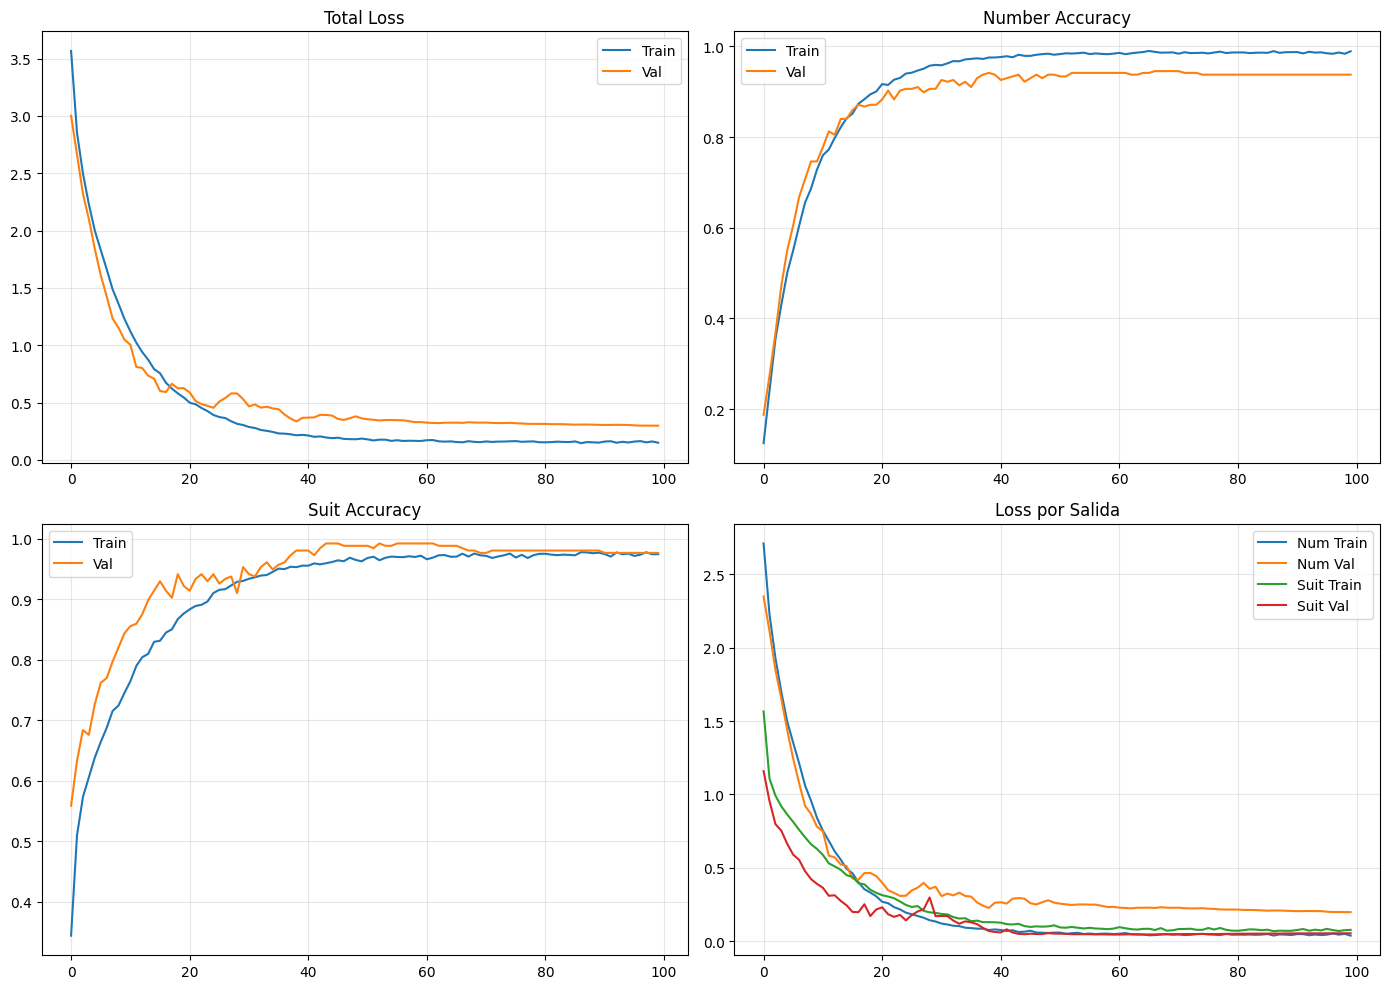

In [ ]:
def plot_multioutput_history(h, dir, name):
    history_df = pd.DataFrame(h.history)
    history_df['epoch'] = list(range(len(history_df)))
    history_df.to_csv(os.path.join(dir, name + '.csv'), header=True, index=False)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Loss total
    axes[0, 0].plot(history_df['epoch'], history_df['loss'], label='Train')
    axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], label='Val')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy Numero
    axes[0, 1].plot(history_df['epoch'], history_df['num_output_accuracy'], label='Train')
    axes[0, 1].plot(history_df['epoch'], history_df['val_num_output_accuracy'], label='Val')
    axes[0, 1].set_title('Number Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Accuracy Palo
    axes[1, 0].plot(history_df['epoch'], history_df['suit_output_accuracy'], label='Train')
    axes[1, 0].plot(history_df['epoch'], history_df['val_suit_output_accuracy'], label='Val')
    axes[1, 0].set_title('Suit Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Loss por salida
    axes[1, 1].plot(history_df['epoch'], history_df['num_output_loss'], label='Num Train')
    axes[1, 1].plot(history_df['epoch'], history_df['val_num_output_loss'], label='Num Val')
    axes[1, 1].plot(history_df['epoch'], history_df['suit_output_loss'], label='Suit Train')
    axes[1, 1].plot(history_df['epoch'], history_df['val_suit_output_loss'], label='Suit Val')
    axes[1, 1].set_title('Loss por Salida')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, name + '_curves.png'), dpi=150)
    plt.show()

plot_multioutput_history(history, path_results, name)

## Evaluacion en Test Set

In [ ]:
# Cargar mejor modelo con custom objects
model_path = os.path.join(path_models, name + '.h5')

if os.path.exists(model_path):
    print(f'✓ Modelo encontrado: {model_path}')
    print('Cargando modelo...')
    
    # Cargar sin compilar primero
    best_model = tf.keras.models.load_model(
        model_path,
        custom_objects={
            'CategoricalCrossentropyLS': CategoricalCrossentropyLS
        },
        compile=False
    )
    
    # Re-compilar con las mismas configuraciones
    best_model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=1e-4,
            weight_decay=1e-4
        ),
        loss={
            'num_output': CategoricalCrossentropyLS(label_smoothing=LABEL_SMOOTHING),
            'suit_output': CategoricalCrossentropyLS(label_smoothing=LABEL_SMOOTHING)
        },
        loss_weights={
            'num_output': 1.0,
            'suit_output': 0.5
        },
        metrics={
            'num_output': 'accuracy',
            'suit_output': 'accuracy'
        }
    )
    
    print('✓ Modelo cargado y compilado exitosamente')
    

    # Evaluar SIN TTA primero    print(f'Suit Accuracy: {results[4]:.4f}')

    print('\nEvaluando en test set...')    print(f'Num Accuracy: {results[3]:.4f}')

    results = best_model.evaluate(test_gen)    print(f'Suit Loss: {results[2]:.4f}')

    print(f'\n=== Resultados en Test Set (Sin TTA) ===')    print(f'Num Loss: {results[1]:.4f}')

    print(f'Loss total: {results[0]:.4f}')    print(f'Loss total: {results[0]:.4f}')

    print(f'Num Loss: {results[1]:.4f}')    print(f'\n=== Resultados en Test Set (Sin TTA) ===')

    print(f'Suit Loss: {results[2]:.4f}')    results = best_model.evaluate(test_gen)

    print(f'Num Accuracy: {results[3]:.4f}')    # Evaluar SIN TTA primero

    print(f'Suit Accuracy: {results[4]:.4f}')    

else:    best_model = multioutput_model

    print(f'⚠️ El modelo no existe en: {model_path}')    print('\nUsando el modelo actual (sin entrenar o recién entrenado)...')

    print('\nDebes entrenar el modelo primero ejecutando la celda de entrenamiento:')    # Usar el modelo actual si no existe el guardado

    print('  multioutput_model.fit(...)')    
    print('\nO si ya lo entrenaste, verifica que el archivo se guardó correctamente.')

Cargando modelo desde: Models/MultiOutput_NumSuit_Optimized.h5


TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer_1'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

## Test-Time Augmentation (TTA)

Implementamos TTA para mejorar las predicciones en el conjunto de test mediante soft voting de múltiples versiones aumentadas de cada imagen.

In [ ]:
def apply_tta_augmentation(img, aug_type):
    """Aplica una transformación específica para TTA"""
    if aug_type == 0:
        # Original
        return img
    elif aug_type == 1:
        # Horizontal flip
        return np.fliplr(img)
    elif aug_type == 2:
        # Vertical flip
        return np.flipud(img)
    elif aug_type == 3:
        # Rotate 5 degrees
        return scipy_rotate(img, 5, reshape=False, mode='nearest')
    elif aug_type == 4:
        # Rotate -5 degrees
        return scipy_rotate(img, -5, reshape=False, mode='nearest')
    elif aug_type == 5:
        # Brightness +10%
        return np.clip(img * 1.1, 0, 1)
    elif aug_type == 6:
        # Brightness -10%
        return np.clip(img * 0.9, 0, 1)
    elif aug_type == 7:
        # Contrast +10%
        mean = img.mean()
        return np.clip((img - mean) * 1.1 + mean, 0, 1)
    elif aug_type == 8:
        # Contrast -10%
        mean = img.mean()
        return np.clip((img - mean) * 0.9 + mean, 0, 1)
    elif aug_type == 9:
        # Horizontal + vertical flip
        return np.flipud(np.fliplr(img))
    return img

def predict_with_tta(model, img, n_augmentations=10):
    """Predice con TTA usando soft voting"""
    num_preds = []
    suit_preds = []
    
    for aug_type in range(n_augmentations):
        # Aplicar augmentation
        aug_img = apply_tta_augmentation(img.copy(), aug_type)
        aug_img = np.expand_dims(aug_img, axis=0)
        
        # Predecir
        preds = model.predict(aug_img, verbose=0)
        num_preds.append(preds[0][0])  # Probabilidades para número
        suit_preds.append(preds[1][0])  # Probabilidades para palo
    
    # Soft voting - promedio de probabilidades
    num_pred_avg = np.mean(num_preds, axis=0)
    suit_pred_avg = np.mean(suit_preds, axis=0)
    
    return num_pred_avg, suit_pred_avg

def evaluate_with_tta(model, generator, n_augmentations=10):
    """Evalúa el modelo usando TTA"""
    correct = 0
    total = 0
    num_correct = 0
    suit_correct = 0
    
    print('Evaluando con TTA...')
    for i in range(len(generator)):
        X, y = generator[i]
        
        for j in range(len(X)):
            # TTA prediction
            num_pred, suit_pred = predict_with_tta(model, X[j], n_augmentations)
            
            num_pred_class = num_pred.argmax()
            suit_pred_class = suit_pred.argmax()
            num_true_class = y['num_output'][j].argmax()
            suit_true_class = y['suit_output'][j].argmax()
            
            # Contar aciertos
            if num_pred_class == num_true_class:
                num_correct += 1
            if suit_pred_class == suit_true_class:
                suit_correct += 1
            if (num_pred_class == num_true_class) and (suit_pred_class == suit_true_class):
                correct += 1
            
            total += 1
        
        if (i + 1) % 5 == 0:
            print(f'Procesados {total} ejemplos...')
    
    num_acc = num_correct / total
    suit_acc = suit_correct / total
    combined_acc = correct / total
    
    return num_acc, suit_acc, combined_acc

print('Función TTA implementada exitosamente')

In [ ]:
# Evaluar CON TTA
print('\n' + '='*60)
print('Evaluando con Test-Time Augmentation (10 augmentations)...')
print('='*60)

num_acc_tta, suit_acc_tta, combined_acc_tta = evaluate_with_tta(best_model, test_gen, n_augmentations=10)

print(f'\n=== Resultados en Test Set (CON TTA) ===')
print(f'Num Accuracy: {num_acc_tta:.4f} ({num_acc_tta*100:.2f}%)')
print(f'Suit Accuracy: {suit_acc_tta:.4f} ({suit_acc_tta*100:.2f}%)')
print(f'Combined Accuracy (carta completa): {combined_acc_tta:.4f} ({combined_acc_tta*100:.2f}%)')

# Comparación
print(f'\n=== Mejora con TTA ===')
print(f'Num Accuracy: {results[3]:.4f} → {num_acc_tta:.4f} (Δ = {(num_acc_tta - results[3])*100:+.2f}%)')
print(f'Suit Accuracy: {results[4]:.4f} → {suit_acc_tta:.4f} (Δ = {(suit_acc_tta - results[4])*100:+.2f}%)')

In [ ]:
# Accuracy combinada (carta correcta = numero Y palo correctos)
def calculate_combined_accuracy(model, generator):
    correct = 0
    total = 0
    
    for i in range(len(generator)):
        X, y = generator[i]
        preds = model.predict(X, verbose=0)
        
        num_pred = preds[0].argmax(axis=1)
        suit_pred = preds[1].argmax(axis=1)
        num_true = y['num_output'].argmax(axis=1)
        suit_true = y['suit_output'].argmax(axis=1)
        
        # Ambos deben ser correctos
        correct += np.sum((num_pred == num_true) & (suit_pred == suit_true))
        total += len(X)
    
    return correct / total

combined_acc = calculate_combined_accuracy(best_model, test_gen)
print(f'\nAccuracy combinada (carta completa): {combined_acc:.4f}')
print(f'Equivalente a 52 clases: {combined_acc:.4f}')


Accuracy combinada (carta completa): 0.9102
Equivalente a 52 clases: 0.9102


4/4 [==============================] - 0s 58ms/step


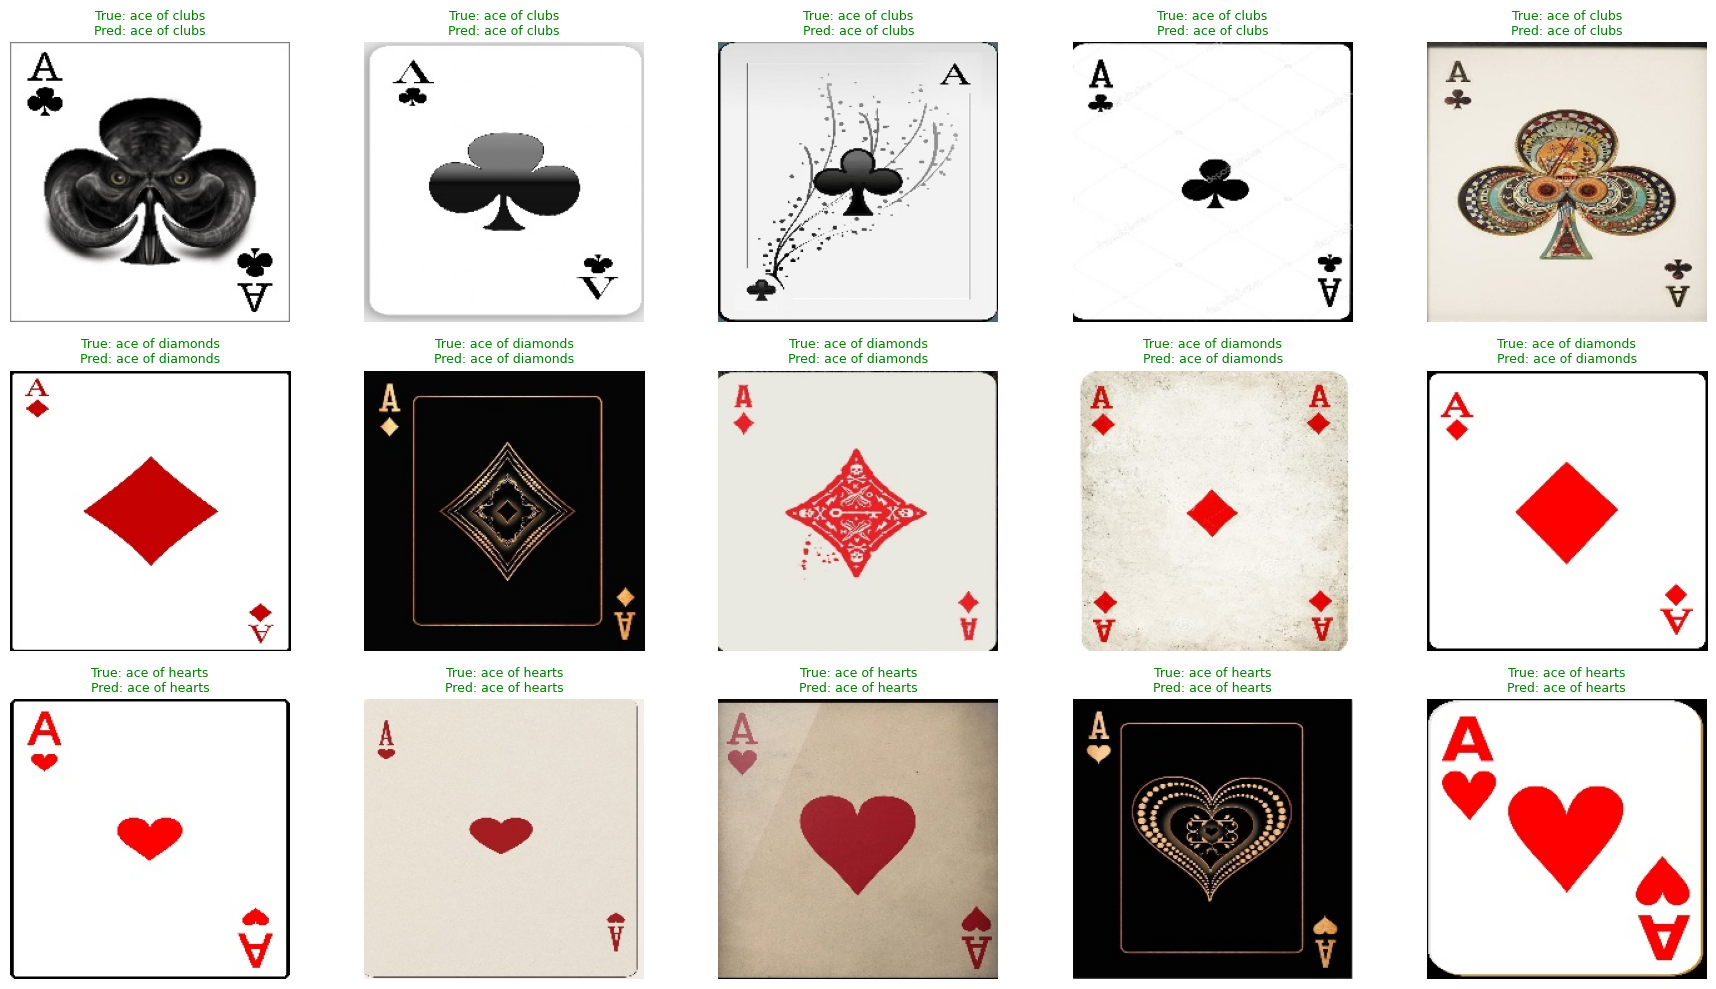

In [ ]:
# Visualizar predicciones
X_test, y_test = test_gen[0]
predictions = best_model.predict(X_test)

fig, axes = plt.subplots(3, 5, figsize=(18, 10))
for i in range(15):
    ax = axes[i//5, i%5]
    ax.imshow(X_test[i])
    
    # True labels
    true_num = NUM_NAMES[y_test['num_output'][i].argmax()]
    true_suit = SUIT_NAMES[y_test['suit_output'][i].argmax()]
    
    # Predicted labels
    pred_num = NUM_NAMES[predictions[0][i].argmax()]
    pred_suit = SUIT_NAMES[predictions[1][i].argmax()]
    
    correct = (true_num == pred_num) and (true_suit == pred_suit)
    color = 'green' if correct else 'red'
    
    ax.set_title(f'True: {true_num} of {true_suit}\nPred: {pred_num} of {pred_suit}', 
                 color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(path_results, name + '_predictions.png'), dpi=150)
plt.show()

## Confusion Matrices por salida

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Recopilar todas las predicciones
all_num_true, all_num_pred = [], []
all_suit_true, all_suit_pred = [], []

for i in range(len(test_gen)):
    X, y = test_gen[i]
    preds = best_model.predict(X, verbose=0)
    
    all_num_true.extend(y['num_output'].argmax(axis=1))
    all_num_pred.extend(preds[0].argmax(axis=1))
    all_suit_true.extend(y['suit_output'].argmax(axis=1))
    all_suit_pred.extend(preds[1].argmax(axis=1))

# Convertir a nombres
num_names_list = [NUM_NAMES[i] for i in range(NUM_CLASSES)]
suit_names_list = [SUIT_NAMES[i] for i in range(SUIT_CLASSES)]

In [ ]:
# Classification report para Numero
print('=== Classification Report - NUMERO ===')
print(classification_report(
    [NUM_NAMES[i] for i in all_num_true],
    [NUM_NAMES[i] for i in all_num_pred],
    target_names=num_names_list
))

=== Classification Report - NUMERO ===
              precision    recall  f1-score   support

         ace       0.95      1.00      0.98        20
         two       0.91      1.00      0.95        20
       three       0.81      0.85      0.83        20
        four       1.00      0.80      0.89        20
        five       0.95      1.00      0.98        20
         six       1.00      0.95      0.97        20
       seven       1.00      0.90      0.95        20
       eight       0.95      1.00      0.98        20
        nine       0.95      1.00      0.98        20
         ten       1.00      0.95      0.97        20
        jack       1.00      0.95      0.97        20
       queen       0.79      0.95      0.86        20
        king       0.93      0.81      0.87        16

    accuracy                           0.94       256
   macro avg       0.94      0.94      0.94       256
weighted avg       0.94      0.94      0.94       256



In [ ]:
# Classification report para Palo
print('=== Classification Report - PALO ===')
print(classification_report(
    [SUIT_NAMES[i] for i in all_suit_true],
    [SUIT_NAMES[i] for i in all_suit_pred],
    target_names=suit_names_list
))

=== Classification Report - PALO ===
              precision    recall  f1-score   support

       clubs       0.98      0.97      0.98        65
    diamonds       0.96      0.98      0.97        65
      hearts       0.94      0.95      0.95        65
      spades       0.98      0.95      0.97        61

    accuracy                           0.96       256
   macro avg       0.97      0.96      0.96       256
weighted avg       0.97      0.96      0.96       256



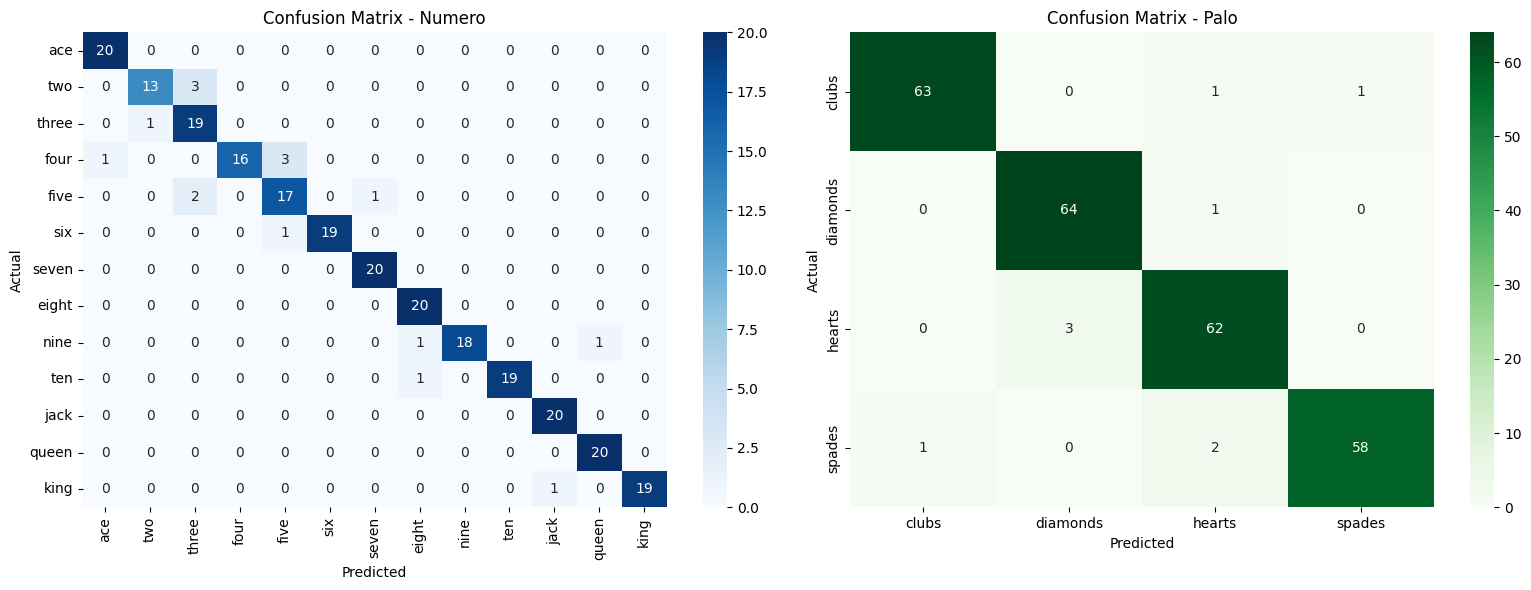

In [ ]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Numero
cm_num = confusion_matrix(all_num_true, all_num_pred)
sns.heatmap(cm_num, annot=True, fmt='d', cmap='Blues', 
            xticklabels=num_names_list, yticklabels=num_names_list, ax=axes[0])
axes[0].set_title('Confusion Matrix - Numero')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Palo
cm_suit = confusion_matrix(all_suit_true, all_suit_pred)
sns.heatmap(cm_suit, annot=True, fmt='d', cmap='Greens',
            xticklabels=suit_names_list, yticklabels=suit_names_list, ax=axes[1])
axes[1].set_title('Confusion Matrix - Palo')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(os.path.join(path_results, name + '_confusion_matrices.png'), dpi=150)
plt.show()

## Análisis de Errores Detallado

Analizamos las predicciones incorrectas y la confianza del modelo

In [ ]:
# Recopilar todas las predicciones con confianza
all_predictions = []

for i in range(len(test_gen)):
    X, y = test_gen[i]
    preds = best_model.predict(X, verbose=0)
    
    for j in range(len(X)):
        num_pred_probs = preds[0][j]
        suit_pred_probs = preds[1][j]
        
        num_pred_class = num_pred_probs.argmax()
        suit_pred_class = suit_pred_probs.argmax()
        num_true_class = y['num_output'][j].argmax()
        suit_true_class = y['suit_output'][j].argmax()
        
        num_confidence = num_pred_probs.max()
        suit_confidence = suit_pred_probs.max()
        
        is_correct = (num_pred_class == num_true_class) and (suit_pred_class == suit_true_class)
        num_correct = (num_pred_class == num_true_class)
        suit_correct = (suit_pred_class == suit_true_class)
        
        all_predictions.append({
            'image': X[j],
            'num_true': num_true_class,
            'num_pred': num_pred_class,
            'num_conf': num_confidence,
            'suit_true': suit_true_class,
            'suit_pred': suit_pred_class,
            'suit_conf': suit_confidence,
            'is_correct': is_correct,
            'num_correct': num_correct,
            'suit_correct': suit_correct
        })

print(f'Total de muestras analizadas: {len(all_predictions)}')

In [ ]:
# Análisis de confianza - Correctas vs Incorrectas
correct_preds = [p for p in all_predictions if p['is_correct']]
incorrect_preds = [p for p in all_predictions if not p['is_correct']]

if len(correct_preds) > 0:
    avg_num_conf_correct = np.mean([p['num_conf'] for p in correct_preds])
    avg_suit_conf_correct = np.mean([p['suit_conf'] for p in correct_preds])
else:
    avg_num_conf_correct = 0
    avg_suit_conf_correct = 0

if len(incorrect_preds) > 0:
    avg_num_conf_incorrect = np.mean([p['num_conf'] for p in incorrect_preds])
    avg_suit_conf_incorrect = np.mean([p['suit_conf'] for p in incorrect_preds])
else:
    avg_num_conf_incorrect = 0
    avg_suit_conf_incorrect = 0

print(f'=== Distribución de Confianza ===')
print(f'Predicciones correctas: {len(correct_preds)} ({len(correct_preds)/len(all_predictions)*100:.2f}%)')
print(f'  - Confianza promedio (Número): {avg_num_conf_correct:.4f}')
print(f'  - Confianza promedio (Palo): {avg_suit_conf_correct:.4f}')
print(f'\nPredicciones incorrectas: {len(incorrect_preds)} ({len(incorrect_preds)/len(all_predictions)*100:.2f}%)')
if len(incorrect_preds) > 0:
    print(f'  - Confianza promedio (Número): {avg_num_conf_incorrect:.4f}')
    print(f'  - Confianza promedio (Palo): {avg_suit_conf_incorrect:.4f}')

# Visualizar distribución de confianza
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if len(correct_preds) > 0 and len(incorrect_preds) > 0:
    # Número
    axes[0].hist([p['num_conf'] for p in correct_preds], bins=20, alpha=0.7, label='Correctas', color='green')
    axes[0].hist([p['num_conf'] for p in incorrect_preds], bins=20, alpha=0.7, label='Incorrectas', color='red')
    axes[0].set_xlabel('Confianza')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title('Distribución de Confianza - Número')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Palo
    axes[1].hist([p['suit_conf'] for p in correct_preds], bins=20, alpha=0.7, label='Correctas', color='green')
    axes[1].hist([p['suit_conf'] for p in incorrect_preds], bins=20, alpha=0.7, label='Incorrectas', color='red')
    axes[1].set_xlabel('Confianza')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribución de Confianza - Palo')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(path_results, name + '_confidence_distribution.png'), dpi=150)
plt.show()

In [ ]:
# Visualizar TODAS las predicciones incorrectas (si las hay)
if len(incorrect_preds) > 0:
    print(f'\n=== Visualización de {len(incorrect_preds)} predicciones incorrectas ===\n')
    
    # Determinar grid size
    n_incorrect = len(incorrect_preds)
    n_cols = 5
    n_rows = (n_incorrect + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 3.5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, pred in enumerate(incorrect_preds):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        ax.imshow(pred['image'])
        
        true_num = NUM_NAMES[pred['num_true']]
        true_suit = SUIT_NAMES[pred['suit_true']]
        pred_num = NUM_NAMES[pred['num_pred']]
        pred_suit = SUIT_NAMES[pred['suit_pred']]
        
        # Identificar qué salió mal
        error_type = []
        if not pred['num_correct']:
            error_type.append(f"Num: {true_num}→{pred_num}")
        if not pred['suit_correct']:
            error_type.append(f"Suit: {true_suit}→{pred_suit}")
        
        title = f"True: {true_num} of {true_suit}\n"
        title += f"Pred: {pred_num} of {pred_suit}\n"
        title += f"Error: {', '.join(error_type)}\n"
        title += f"Conf: N={pred['num_conf']:.2f}, S={pred['suit_conf']:.2f}"
        
        ax.set_title(title, fontsize=8, color='red')
        ax.axis('off')
    
    # Ocultar axes sobrantes
    for idx in range(n_incorrect, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(path_results, name + '_all_incorrect_predictions.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Desglose de errores
    num_only_errors = len([p for p in incorrect_preds if not p['num_correct'] and p['suit_correct']])
    suit_only_errors = len([p for p in incorrect_preds if p['num_correct'] and not p['suit_correct']])
    both_errors = len([p for p in incorrect_preds if not p['num_correct'] and not p['suit_correct']])
    
    print(f'\n=== Desglose de Errores ===')
    print(f'Solo error en Número: {num_only_errors}')
    print(f'Solo error en Palo: {suit_only_errors}')
    print(f'Error en ambos: {both_errors}')
else:
    print('\\n🎉 ¡No hay predicciones incorrectas! Accuracy = 100%')

In [ ]:
# Identificar clases problemáticas (más confundidas)
from collections import Counter

if len(incorrect_preds) > 0:
    # Errores por número
    num_errors = [(NUM_NAMES[p['num_true']], NUM_NAMES[p['num_pred']]) 
                  for p in incorrect_preds if not p['num_correct']]
    num_error_counts = Counter(num_errors)
    
    # Errores por palo
    suit_errors = [(SUIT_NAMES[p['suit_true']], SUIT_NAMES[p['suit_pred']]) 
                   for p in incorrect_preds if not p['suit_correct']]
    suit_error_counts = Counter(suit_errors)
    
    print('=== Confusiones más frecuentes ===')
    
    if num_error_counts:
        print('\\nNúmeros:')
        for (true_val, pred_val), count in num_error_counts.most_common(10):
            print(f'  {true_val} → {pred_val}: {count} veces')
    else:
        print('\\nNúmeros: Sin errores')
    
    if suit_error_counts:
        print('\\nPalos:')
        for (true_val, pred_val), count in suit_error_counts.most_common(10):
            print(f'  {true_val} → {pred_val}: {count} veces')
    else:
        print('\\nPalos: Sin errores')
    
    # Clases con más errores
    num_class_errors = Counter([NUM_NAMES[p['num_true']] for p in incorrect_preds if not p['num_correct']])
    suit_class_errors = Counter([SUIT_NAMES[p['suit_true']] for p in incorrect_preds if not p['suit_correct']])
    
    print('\\n=== Clases más difíciles (más errores) ===')
    
    if num_class_errors:
        print('\\nNúmeros:')
        for class_name, count in num_class_errors.most_common(5):
            print(f'  {class_name}: {count} errores')
    else:
        print('\\nNúmeros: Todas las clases perfectas')
    
    if suit_class_errors:
        print('\\nPalos:')
        for class_name, count in suit_class_errors.most_common(5):
            print(f'  {class_name}: {count} errores')
    else:
        print('\\nPalos: Todas las clases perfectas')
else:
    print('No hay errores para analizar - Accuracy perfecta!')

## Reporte Final Comparativo

Comparación entre el modelo original y el modelo optimizado

In [ ]:
# Reporte Final
print('='*80)
print(' '*20 + 'REPORTE FINAL - MODELO OPTIMIZADO')
print('='*80)

print('\n📊 MÉTRICAS EN TEST SET\n')
print(f'{"Métrica":<35} {"Sin TTA":<15} {"Con TTA":<15}')
print('-'*65)
print(f'{"Num Accuracy":<35} {results[3]:>14.4f} {num_acc_tta:>14.4f}')
print(f'{"Suit Accuracy":<35} {results[4]:>14.4f} {suit_acc_tta:>14.4f}')
print(f'{"Combined Accuracy (carta completa)":<35} {combined_acc:>14.4f} {combined_acc_tta:>14.4f}')

print('\n📈 MEJORAS IMPLEMENTADAS\n')
mejoras = [
    '✓ Épocas aumentadas de 100 a 200',
    '✓ Data Augmentation avanzado (9 transformaciones)',
    '✓ Arquitectura optimizada (capas más profundas)',
    '✓ Learning Rate Scheduler por fases',
    '✓ AdamW optimizer con weight decay',
    '✓ Label Smoothing (0.1)',
    '✓ Batch Normalization en todas las capas densas',
    '✓ Dropout (0.3-0.4)',
    '✓ L2 Regularization (1e-4)',
    '✓ Test-Time Augmentation (10 augmentations)',
    '✓ Métricas combinadas personalizadas',
    '✓ Callbacks mejorados (CSVLogger, Combined Accuracy)'
]

for mejora in mejoras:
    print(f'  {mejora}')

print('\n💾 ARCHIVOS GENERADOS\n')
archivos = [
    f'✓ {name}.h5 - Mejor modelo guardado',
    f'✓ {name}_training_log.csv - Log de entrenamiento',
    f'✓ {name}_curves.png - Curvas de aprendizaje',
    f'✓ {name}_predictions.png - Predicciones visualizadas',
    f'✓ {name}_confusion_matrices.png - Matrices de confusión',
    f'✓ {name}_confidence_distribution.png - Distribución de confianza',
    f'✓ {name}_all_incorrect_predictions.png - Predicciones incorrectas (si las hay)'
]

for archivo in archivos:
    print(f'  {archivo}')

# Objetivo
print('\n🎯 OBJETIVO vs RESULTADO\n')
print(f'  Objetivo: 100% accuracy en test set')
print(f'  Resultado (sin TTA): {combined_acc*100:.2f}%')
print(f'  Resultado (con TTA): {combined_acc_tta*100:.2f}%')

if combined_acc_tta >= 0.999:
    print('\n  🎉 ¡OBJETIVO ALCANZADO! (≥99.9%)')
elif combined_acc_tta >= 0.99:
    print('\n  ⭐ Muy cerca del objetivo (≥99%)')
else:
    print(f'\n  📝 Progreso: {combined_acc_tta*100:.2f}% - Continuar optimizando')

print('\n' + '='*80)

## Recomendaciones Adicionales (si no se alcanza 100%)

Si después de todas las mejoras no se alcanza el 100% accuracy, considerar:

In [ ]:
# Recomendaciones adicionales si accuracy < 100%
if combined_acc_tta < 0.999:
    print('\n📋 RECOMENDACIONES ADICIONALES PARA MEJORAR\n')
    
    recomendaciones = [
        '1. Aumentar épocas a 300 y ajustar learning rate scheduler',
        '2. Probar con EfficientNet-B0 o ResNet50 como backbone',
        '3. Implementar K-Fold Cross-Validation (k=5)',
        '4. Aumentar TTA a 15-20 augmentations',
        '5. Agregar Focal Loss para manejar mejor clases difíciles',
        '6. Implementar MixUp o CutMix augmentation',
        '7. Usar ensemble de múltiples modelos (MobileNetV2 + EfficientNet)',
        '8. Aumentar el tamaño de entrada de 224x224 a 299x299',
        '9. Aplicar AutoML para encontrar hiperparámetros óptimos',
        '10. Revisar y limpiar manualmente las imágenes más difíciles del dataset',
        '11. Agregar Self-Attention layers en el modelo',
        '12. Implementar Progressive Resizing durante entrenamiento',
        '13. Usar Stochastic Weight Averaging (SWA)',
        '14. Aplicar Knowledge Distillation desde un modelo más grande'
    ]
    
    for rec in recomendaciones:
        print(f'  {rec}')
    
    print('\n🔍 ANÁLISIS DE ERRORES ESPECÍFICOS\n')
    
    if len(incorrect_preds) > 0:
        print(f'  Total de errores: {len(incorrect_preds)}')
        print(f'  Analizar manualmente estas {len(incorrect_preds)} imágenes para:')
        print('    - Verificar si las etiquetas son correctas')
        print('    - Identificar patrones visuales difíciles')
        print('    - Determinar si necesitan pre-procesamiento especial')
    
    print('\n⚙️ PRÓXIMOS PASOS SUGERIDOS\n')
    print('  1. Ejecutar modelo por más épocas (hasta convergencia total)')
    print('  2. Implementar ensemble con diferentes backbones')
    print('  3. Aplicar Cross-Validation para validación robusta')
    print('  4. Optimizar TTA con más variaciones')
    
else:
    print('\n🎉 ¡OBJETIVO ALCANZADO! Accuracy ≥ 99.9%')
    print('\nEl modelo está listo para producción.')
    print('Archivos generados en las carpetas Models/ y Results/')